# Import Libraries

In [ ]:
!pip install --quiet tensorflow-federated==0.20.0
!pip install --quiet --upgrade nest-asyncio

import nest_asyncio
nest_asyncio.apply()

In [ ]:
%load_ext tensorboard

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_federated as tff



SEED = 0
tf.random.set_seed(SEED)
np.random.seed(0)

tff.federated_computation(lambda: 'Hello, World!')()

b'Hello, World!'

In [ ]:
tf.__version__

'2.8.2'

In [ ]:
tff.__version__

'0.20.0'

In [ ]:
!python --version

Python 3.7.13


In [ ]:
from tensorflow import keras
from keras.metrics import RootMeanSquaredError
from keras import layers
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from keras.metrics import MeanSquaredError, RootMeanSquaredError, MeanAbsoluteError

from sklearn.model_selection import GroupShuffleSplit
import matplotlib.pyplot as plt


import time


# Load data

In [ ]:
path = "/content/drive/MyDrive/Thesis/Datasets/Pasteurizer_dataset/"

In [ ]:
alice_df = pd.read_csv(path+ "federated/alice_set.csv")
bob_df = pd.read_csv(path+ "federated/bob_set.csv")

test_df = pd.read_csv(path+ "federated/test_set.csv")

In [ ]:
alice_df

In [ ]:
bob_df

In [ ]:
test_df

# Preparing Data

In [ ]:
# Train test numpy arrays
X_alice = alice_df.drop(['curr_can_temp','paster_id'], axis=1).values
y_alice = alice_df['curr_can_temp'].values

X_bob = bob_df.drop(['curr_can_temp','paster_id'], axis=1).values
y_bob = bob_df['curr_can_temp'].values


X_test = test_df.drop(['curr_can_temp','paster_id'], axis=1).values
y_test = test_df['curr_can_temp'].values

In [ ]:
# Min max normalizaiton

min_max_scaler = preprocessing.MinMaxScaler()

X_alice_norm_ = min_max_scaler.fit_transform(X_alice)
X_bob_norm = min_max_scaler.fit_transform(X_bob)
X_test_norm = min_max_scaler.fit_transform(X_test)


In [ ]:
X_alice.shape

(23578, 6)

In [ ]:
y_alice.shape

(23578,)

In [ ]:
X_test.shape

(12178, 6)

In [ ]:
y_alice.shape

(23578,)

In [ ]:
y_alice = y_alice.reshape(y_alice.shape[0],1)
y_bob = y_bob.reshape(y_bob.shape[0],1)
y_test = y_test.reshape(y_test.shape[0],1)

In [ ]:
y_alice.shape

(23578, 1)

# Hyperparameters

In [ ]:
# BATCH_SIZE = 16
# GLOBAL_EPOCHS = 10
# LOCAL_EPOCHS = 25

BATCH_SIZE = 16
GLOBAL_EPOCHS = 10
LOCAL_EPOCHS = 5

# Federated Dataset

In [ ]:
# Use 80% for training and 20% for validation
alice_split = round(X_alice.shape[0] * 0.8)
bob_split = round(X_bob.shape[0] * 0.8)

In [ ]:
train_data, test_data, val_data = [], [], []

temp_dataset = tf.data.Dataset.from_tensor_slices((X_alice[:alice_split], y_alice[:alice_split])).repeat(LOCAL_EPOCHS).batch(BATCH_SIZE)
train_data.append(temp_dataset)
temp_dataset = tf.data.Dataset.from_tensor_slices((X_bob[:bob_split], y_bob[:bob_split])).repeat(LOCAL_EPOCHS).batch(BATCH_SIZE)
train_data.append(temp_dataset)


temp_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_data.append(temp_dataset.batch(1))

X_val = np.concatenate([X_alice[alice_split:],X_bob[bob_split:]])
y_val = np.concatenate([y_alice[alice_split:],y_bob[bob_split:]])

temp_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_data.append(temp_dataset.batch(BATCH_SIZE))

In [ ]:
train_data

[<BatchDataset element_spec=(TensorSpec(shape=(None, 6), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>,
 <BatchDataset element_spec=(TensorSpec(shape=(None, 6), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>]

In [ ]:
val_data

[<BatchDataset element_spec=(TensorSpec(shape=(None, 6), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>]

# Create Model

In [ ]:
def input_spec():
    return (
        tf.TensorSpec([None, 6], tf.float64),
        tf.TensorSpec([None, 1], tf.float64)
    )

def model_fn(centralized=False):
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(6,)),                                       
        tf.keras.layers.Dense(20, activation='relu'),
        tf.keras.layers.Dense(1, activation='relu'),
    ])

    if centralized:
      return model
    else:
      return tff.learning.from_keras_model(
          model,
          input_spec=input_spec(),
          loss=tf.keras.losses.MeanSquaredError(),
          metrics=[MeanAbsoluteError(),RootMeanSquaredError(), MeanSquaredError()])

# Training

In [ ]:
trainer = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.Adam(),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate = 0.1)
)

In [ ]:
# creating the directory and the corresponding summary writer to write the metrics to

#@test {"skip": true}
logdir = "/tmp/logs/scalars/training/"
summary_writer = tf.summary.create_file_writer(logdir)
state = trainer.initialize()

In [ ]:
evaluator = tff.learning.build_federated_evaluation(model_fn)

In [ ]:


state = trainer.initialize()
train_hist = []

losses = []
mae = []

val_losses = []
val_mae = []


start = time.time()
with summary_writer.as_default():
  for round_num in range(GLOBAL_EPOCHS):
      state, metrics = trainer.next(state, train_data)
      for name, value in metrics['train'].items():
        tf.summary.scalar(name, value, step=round_num)

      train_hist.append(metrics)

      losses.append(metrics['train']['loss'])
      mae.append(metrics['train']['mean_absolute_error'])


      val_metrics = evaluator(state.model, val_data)
      val_losses.append(val_metrics['eval']['loss'])
      val_mae.append(val_metrics['eval']['mean_absolute_error'])

      print(f"\rRun {round_num+1}/{GLOBAL_EPOCHS}    ", end="")
      print("loss(mse): {loss} MAE: {mae}".format(mae = metrics["train"]['mean_absolute_error'], loss = metrics["train"]['loss']))
end = time.time()
print(f"Training time {end - start:.2f} sec")

Run 1/10    loss(mse): 2824.995361328125 MAE: 52.297664642333984
Run 2/10    loss(mse): 2824.995361328125 MAE: 52.297664642333984
Run 3/10    loss(mse): 2824.995361328125 MAE: 52.297664642333984
Run 4/10    loss(mse): 2824.995361328125 MAE: 52.297664642333984
Run 5/10    loss(mse): 2824.995361328125 MAE: 52.297664642333984
Run 6/10    loss(mse): 2824.995361328125 MAE: 52.297664642333984
Run 7/10    loss(mse): 2824.995361328125 MAE: 52.297664642333984
Run 8/10    loss(mse): 2824.995361328125 MAE: 52.297664642333984
Run 9/10    loss(mse): 2824.995361328125 MAE: 52.297664642333984
Run 10/10    loss(mse): 2824.995361328125 MAE: 52.297664642333984
Training time 48.34 sec


In [ ]:
val_mae

[52.053127,
 52.053127,
 52.053127,
 52.053127,
 52.053127,
 52.053127,
 52.053127,
 52.053127,
 52.053127,
 52.053127]

In [ ]:

federated_metrics = evaluator(state.model, train_data)
federated_metrics

OrderedDict([('eval',
              OrderedDict([('mean_absolute_error', 52.297665),
                           ('root_mean_squared_error', 53.150684),
                           ('mean_squared_error', 2824.9954),
                           ('loss', 2824.9954),
                           ('num_examples', 187885),
                           ('num_batches', 11744)]))])

In [ ]:

federated_metrics = evaluator(state.model, test_data)
federated_metrics

OrderedDict([('eval',
              OrderedDict([('mean_absolute_error', 52.391922),
                           ('root_mean_squared_error', 53.262913),
                           ('mean_squared_error', 2836.9377),
                           ('loss', 2836.9377),
                           ('num_examples', 12178),
                           ('num_batches', 12178)]))])

# Plot

In [ ]:
evaluator = tff.learning.build_federated_evaluation(model_fn)

In [ ]:
def plot(train, valid, name):
    plt.figure(figsize=(5,5))
    plt.plot(range(1, len(train)+1), train, label='train')
    plt.plot(range(1, len(valid)+1), valid, label='validate')
    plt.xlabel('Rounds')
    plt.ylabel(name)
    plt.legend()
    plt.show()

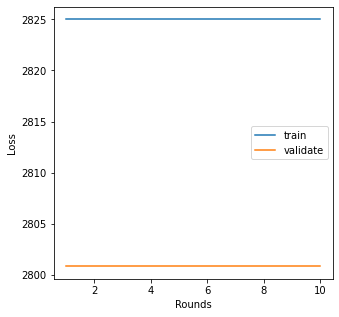

In [ ]:
plot(losses, val_losses, 'Loss')

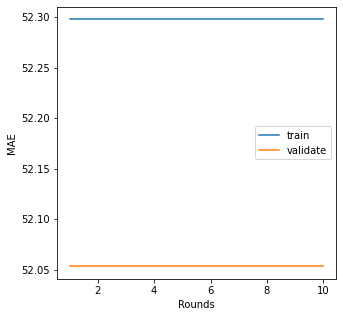

In [ ]:
plot(mae,val_mae,"MAE")

In [ ]:
# #@test {"skip": true}
# !ls {logdir}
# %tensorboard --logdir {logdir} --port=0

# Evaluation

In [ ]:
centralized_model = model_fn(centralized=True)

In [ ]:
# centralized_model.get_weights()

In [ ]:
centralized_model.compile(
      loss=tf.keras.losses.MeanSquaredError(),
      metrics=[RootMeanSquaredError()])
state.model.assign_weights_to(centralized_model)

In [ ]:
def evaluate(y_true, y_hat, label='test'):
    mae = mean_absolute_error(y_true, y_hat)
    mse = mean_squared_error(y_true, y_hat)
    rmse = mean_squared_error(y_true, y_hat, squared=False)
    variance = r2_score(y_true, y_hat)
    print('{} set: MAE:{} RMSE:{}, MSE:{}, R2:{}'.format(label,mae, rmse, mse, variance))

In [ ]:
y_hat_test = centralized_model.predict(X_test)
evaluate(y_test, y_hat_test)

test set: MAE:52.39202906881261 RMSE:53.26295433931122, MSE:2836.9423049515517, R2:-29.83043307989783


In [ ]:
y_test

array([[28.1 ],
       [28.27],
       [28.54],
       ...,
       [42.69],
       [42.41],
       [42.17]])